# Import Relevant Libraries

In [1]:
from __future__ import annotations

import argparse, re, zipfile, tempfile, shutil
from pathlib import Path
from typing import List

import pandas as pd
import numpy as np
import rasterio
import xarray as xr

import urllib
import netCDF4
import datetime
from pathlib import Path

import re
import os

import rioxarray  # activates the .rio accessor

# Define Custom Functions

In [2]:

# ─────────────────────────────── USER SETTINGS ────────────────────────────────
DATE_REGEX = re.compile(r"(?P<date>\d{8})")   # captures the YYYYMMDD token
# ──────────────────────────────────────────────────────────────────────────────

def extract_tif(archive: Path, tmpdir: Path) -> Path:
    """Unzip *archive* and return path to the first .tif it contains."""
    with zipfile.ZipFile(archive) as z:
        tif_names = [n for n in z.namelist() if n.lower().endswith(".tif")]
        if not tif_names:
            raise ValueError(f"No GeoTIFF found in {archive}")
        member = tif_names[0]
        output_path = tmpdir / member
        if output_path.exists():
            output_path.unlink()
        return Path(z.extract(member, path=tmpdir))

def extract_date_from_name(name: str) -> pd.Timestamp:
    """Return a pandas‐Timestamp from an 8-digit token in a filename."""
    m = DATE_REGEX.search(name)
    if not m:
        raise ValueError(f"Couldn't find YYYYMMDD in '{name}'")
    return pd.to_datetime(m.group("date"), format="%Y%m%d")

def load_one_day(path: Path) -> xr.DataArray:
    """
    Open a single-band TIFF and return a DataArray with a 'time' coordinate.
    The variable name is inferred from the filename prefix before the date.
    """
    # e.g. "precip_20250123.tif"  ➜  var_name = "precip"
    var_name = DATE_REGEX.sub("", path.stem).rstrip("_") or "variable"
    arr = rioxarray.open_rasterio(path, masked=True).squeeze("band", drop=True)
    arr = arr.expand_dims(time=[extract_date_from_name(path.name)])
    arr.name = var_name
    # Rename spatial dims for CF friendliness
    #arr = arr.rename({"x": "lon", "y": "lat"})
    return arr

def lumpnetcdf(inputdir, outputdir) -> None:
    tifs = sorted(inputdir.glob("*.tif"))
    if not tifs:
        raise SystemExit(f"No GeoTIFFs found in {inputdir}")

    # Bucket file paths by calendar year
    files_by_year: dict[int, list[Path]] = {}
    for p in tifs:
        yr = extract_date_from_name(p.name).year
        files_by_year.setdefault(yr, []).append(p)

    for year, fpaths in files_by_year.items():
        print(f"▶ {year}: stacking {len(fpaths):,} files …")
        # Load daily rasters into memory-mapped dask chunks (for large data)
        arrays = [load_one_day(p) for p in fpaths]
        ds = xr.concat(arrays, dim="time").sortby("time")

        # CF global attrs
        ds.attrs.update(
            dict(
                title=f"{ds.name} daily—{year}",
                summary="Generated by combine_tifs_to_netcdf.py",
                Conventions="CF-1.9",
                source="Daily GeoTIFF stack",
            )
        )

        # Optional compression
        encoding = {ds.name: {"zlib": True, "complevel": 4}}

        out_nc = outputdir / f"{ds.name}_{year}.nc"
        ds.to_netcdf(out_nc, encoding=encoding)
        print(f"   ✔ wrote {out_nc.relative_to(outputdir.parent)}")


# Define Download Paths

In [4]:
prism_path = Path("E:/UGS_Flux/Projects_and_Proposals/Castledale_ET/Castledale_SWB/cottonwood_SWB_30m/prism_netcdf")
out_path = Path(r"E:\UGS_Flux\Projects_and_Proposals\Castledale_ET\Castledale_SWB\cottonwood_SWB_30m\prism_tmin")
out_tmin_path = out_path / "prism_tmin"
out_tmax_path = out_path / "prism_tmax"
out_ppt_path = out_path / "prism_ppt"

# Download PRISM Data

In [ ]:
# set up parameters; see info here https://prism.oregonstate.edu/documents/PRISM_downloads_web_service.pdf
region = 'us'
res = '4km'
filetype = 'nc' # options include nc, asc, and bil; otherwise default is Cloud-Optimized GeoTIFF
variables = ['ppt', 'tmin', 'tmax'] # parameters you want to download

start_year = 2010
end_year = 2014

for year in range(start_year, end_year+1):
    start_date = datetime.date(year, 1, 1)
    end_date = datetime.date(year, 12, 31)
    dates_in_year =  [(start_date + datetime.timedelta(days=i)) for i in range((end_date - start_date).days + 1)]
    formatted_dates = [date_obj.strftime("%Y%m%d") for date_obj in dates_in_year]
    for var in variables:
        for formatted_date in formatted_dates:
            url = f'https://services.nacse.org/prism/data/get/{region}/{res}/{var}/{formatted_date}/{filetype}'
            filename = prism_path / f'{var}_{formatted_date}.nc'
            urllib.request.urlretrieve(url, filename)

# Extract downloaded files

In [ ]:
datasets = {"tmin":out_tmin_path,
            "tmax":out_tmax_path,
            "ppt":out_ppt_path}

for key,value in datasets.items():

    for file in prism_path.glob(f"*{key}*.nc"):
        try:
            print(file)
            extract_tif(file, value)
        except Exception as e:
            print(e)
            pass 

# Lump Unzipped Files into NetCDF files

In [ ]:
for dataset in ['ppt','tmax','tmin']:
    main_dir = Path(r"E:\UGS_Flux\Projects_and_Proposals\Castledale_ET\Castledale_SWB\cottonwood_SWB_30m")
    inputdir  = main_dir / "prism_tiffs" / f"prism_{dataset}"   # folder with *.tif files
    outputdir = main_dir / "prism_nc" / f"{dataset}_netcdf"    # where yearly NetCDFs will land
    outputdir.mkdir(parents=True, exist_ok=True)
    lumpnetcdf(inputdir, outputdir)

# Reproject and Clip Files

In [9]:
import rioxarray
from pyproj import CRS

rast_path = Path(r'E:\UGS_Flux\Projects_and_Proposals\Castledale_ET\Castledale_SWB\cottonwood_SWB_30m\prism_nc\tmax_netcdf')
out_path = Path(r'C:\Users\paulinkenbrandt\Documents\ArcGIS\Projects\UFN\SWB\netcdf')

var_dict = {"ppt":"prcp",
            "tmax":"tmax",
            "tmin":"tmin",}


out_path = Path(r'C:\Users\paulinkenbrandt\Documents\ArcGIS\Projects\UFN\SWB\netcdfs')


for key in var_dict.keys():
    rast_path = Path(f'E:/UGS_Flux/Projects_and_Proposals/Castledale_ET/Castledale_SWB/cottonwood_SWB_30m/prism_nc/{key}_netcdf')
    for file in rast_path.glob("*.nc"):
        out_var = str(file.stem).split("_")[1]
        year = str(file.stem).split("_")[-1]
        ds = xr.open_dataset(file)
        ds = ds.rio.write_crs("EPSG:4269")
         
        ds = ds.rename({f"prism_{out_var}_us_25m": var_dict[out_var]}) 
        
        # Select the first time slice and the first 10 rows and columns
        subset = ds.where((ds.x > -115)&(ds.x < -108)&(ds.y > 36)&(ds.y < 43), drop=True)

                # Albers Equal Area for CONUS
        aea_crs = CRS.from_epsg(5070)
        # Reproject to Albers Equal Area
        da_reproj = subset.rio.reproject(aea_crs)
        da_reproj = da_reproj.transpose("time", "y", "x")

        origin = np.datetime64(f"{year}-01-01")
        numeric_time = (
            (da_reproj.time.values - origin) / np.timedelta64(1, "D")
        ).astype("float64")
        
        da_reproj = da_reproj.assign_coords(time=("time", numeric_time))
        da_reproj.time.attrs.update({
            "units": f"days since {year}-01-01 00:00:00",
            "calendar": "gregorian"             # SWB understands the default cal-type
        })
        
        da_reproj.attrs.update({
            "title": "PRISM daily precipitation (Utah, 2020)",
            "Conventions": "CF-1.6",
            "time_coverage_start": f"{year}-01-01",
            "time_coverage_end":   f"{year}-12-31"
        })

        dest = out_path / f"prism_ut_{out_var}_{year}.nc"
        da_reproj.to_netcdf(
            dest,
            engine="netcdf4",
            format="NETCDF4",
            unlimited_dims=["time"],
            encoding={               # keep data compressed the same way, if you like
                f"{var_dict[out_var]}": {"zlib": True, "complevel": 4},
                "time": {"dtype": "float64"}     # the critical line
            }
        )

#subset['prcp'].groupby('time.year').sum(dim='time').plot()

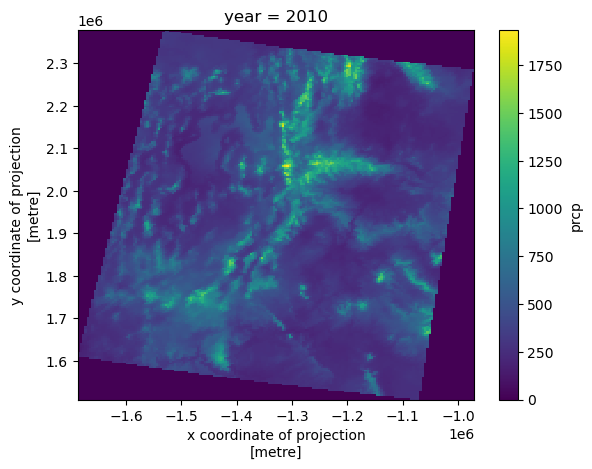

In [4]:
ds = xr.open_dataset(r'C:\Users\paulinkenbrandt\Documents\ArcGIS\Projects\UFN\SWB\netcdfs\prism_ut_ppt_2010.nc')
daymet = xr.open_dataset(r'E:\UGS_Flux\Projects_and_Proposals\Castledale_ET\Castledale_SWB\cottonwood_SWB_30m\netcdfs\tmax_Daymet_v4_2012.nc')
ds['prcp'].groupby('time.year').sum(dim='time').plot()


In [5]:
ds

<xarray.Dataset> Size: 53MB
Dimensions:      (x: 173, y: 210, time: 365)
Coordinates:
  * x            (x) float64 1kB -1.685e+06 -1.681e+06 ... -9.769e+05 -9.727e+05
  * y            (y) float64 2kB 2.377e+06 2.373e+06 ... 1.515e+06 1.511e+06
  * time         (time) datetime64[ns] 3kB 2010-01-01 2010-01-02 ... 2010-12-31
Data variables:
    spatial_ref  int64 8B ...
    prcp         (time, y, x) float32 53MB ...

In [6]:
daymet

<xarray.Dataset> Size: 26MB
Dimensions:                  (time: 365, y: 132, x: 131)
Coordinates:
  * time                     (time) datetime64[ns] 3kB 2012-01-01T12:00:00 .....
  * y                        (y) float32 528B -207.0 -208.0 ... -337.0 -338.0
  * x                        (x) float32 524B -977.2 -976.2 ... -848.2 -847.2
Data variables:
    tmax                     (time, y, x) float32 25MB ...
    lambert_conformal_conic  int16 2B ...
    lat                      (y, x) float64 138kB ...
    lon                      (y, x) float64 138kB ...
Attributes:
    start_year:          2012
    source:              Daymet Software Version 4.0
    Version_software:    Daymet Software Version 4.0
    Version_data:        Daymet Data Version 4.0
    Conventions:         CF-1.6
    citation:            Please see http://daymet.ornl.gov/ for current Dayme...
    references:          Please see http://daymet.ornl.gov/ for current infor...
    History:             Translated to CF-1.0 Conventions by Netcdf-Java CDM ...
    geospatial_lat_min:  38.65485451581665
    geospatial_lat_max:  40.051660185776164
    geospatial_lon_min:  -112.00864787709568
    geospatial_lon_max:  -110.21970298933283